# Consolidated Machine Failure Analysis

## Libraries

In [1]:
# 3rd party
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
try:
    import dtreeviz
    %config InlineBackend.figure_format = 'retina' # Make visualizations look good
except:
    print('Please run "conda uninstall python-graphviz; conda uninstall graphviz; pip install dtreeviz" to install the tree visualization library')   
%matplotlib inline

# standard library
import time

# internal imports
from exploratory_analysis import util  # make_difference_features, make_multiplicative_features, calculate_and_display_accuracy

# constants
RANDOM_SEED = 42
TEST_SIZE = 0.2

## Preprocessing

In [16]:
data = pd.read_csv("machine failure.csv")

# combine failure types into one overall failure column
data['Machine failure'] = np.where((data['TWF'] == 1) | (data['HDF'] == 1) | (data['PWF'] == 1) | (data['OSF'] == 1), 1, 0)
# drop unneeded columns
data.drop(['UDI','Product ID', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1, inplace=True)

# add interaction features
subtraction_columns = util.make_difference_features(data.drop(columns=['Machine failure', 'Type']))
multiplication_columns = util.make_multiplicative_features(data.drop(columns=['Machine failure', 'Type']))
data = pd.concat([data, subtraction_columns, multiplication_columns], axis=1)

# perform different methods of transforming the quality
mapped_data = data.copy()
dummied_data = data.copy()

#### Mapping the quality type without one-hot encoding

In [17]:
# directly map the quality type without one-hot encoding
quality_map = {'L': 1, 'M': 2, 'H': 3}
mapped_data['Type'] = mapped_data['Type'].map(quality_map)

#### One-hot encoding the quality type

In [18]:
# one-hot encode the quality type
dummied_data = pd.get_dummies(dummied_data, columns=['Type',])

## Splitting

In [20]:
# split the mapped data
X_map = mapped_data.drop(columns='Machine failure')
y_map = mapped_data['Machine failure']
X_map_train, X_map_test, y_map_train, y_map_test = train_test_split(X_map, y_map, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y_map)

# split the one-hot encoded data
X_dummy = dummied_data.drop(columns='Machine failure')
y_dummy = dummied_data['Machine failure']
X_dummy_train, X_dummy_test, y_dummy_train, y_dummy_test = train_test_split(X_dummy, y_dummy, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y_dummy)


## Standardizing

In [22]:
# standardize the mapped data
scaler = StandardScaler()
columns_to_scale = list(X_map_train.columns)
columns_to_scale.remove('Type')                # type is not numerical and more categorical

X_map_train[columns_to_scale] = scaler.fit_transform(X_map_train[columns_to_scale])
X_map_test[columns_to_scale] = scaler.transform(X_map_test[columns_to_scale])

# standardize the dummied data
X_dummy_train = scaler.fit_transform(X_dummy_train)
X_dummy_test = scaler.transform(X_dummy_test)

## Testing Model Performance

### Neural Networks

### Logistic Regression

### Decision Tree

### Isolation Forest

### Support Vector Machine

### Random Forest

In [26]:
rf_model = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1, max_depth=13, max_features=0.88,
                                  min_samples_leaf=5, n_estimators=115)
rf_model.fit(X_map_train, y_map_train)

RandomForestClassifier(max_depth=13, max_features=0.88, min_samples_leaf=5,
                       n_estimators=115, n_jobs=-1, random_state=42)

In [27]:
util.calculate_and_display_accuracy(rf_model, X_map_train, y_map_train, X_map_test, y_map_test)

Model Training accuracy:                                   0.9952
Model Test accuracy:                                       0.9945
Baseline, Naive model (always guess 0) training accuracy:  0.967
Baseline, Naive model (always guess 0) test accuracy:      0.967


(0.99525, 0.9945, 0.967, 0.967)

In [28]:
test_predictions = rf_model.predict(X_map_test)

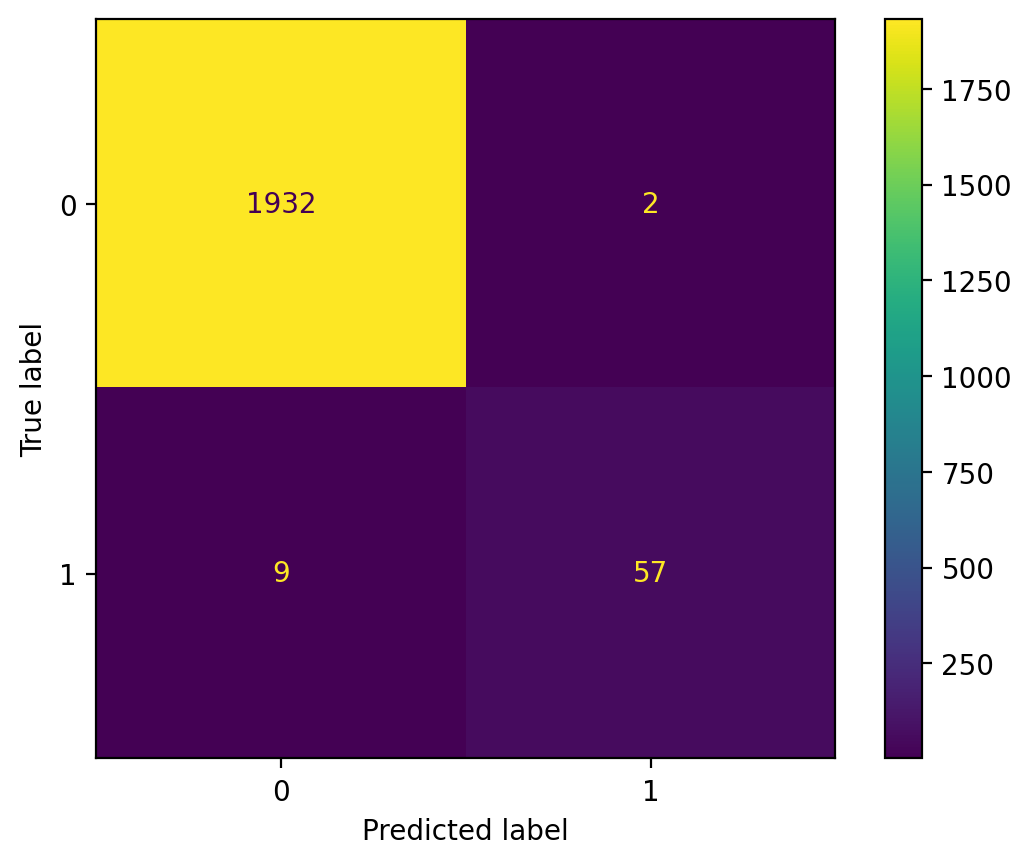

In [33]:
cm = confusion_matrix(y_map_test, test_predictions, labels=rf_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot()
#plt.savefig('random_forest_test_confusion_matrix.svg', format='svg', bbox_inches='tight')

In [30]:
print(classification_report(y_map_test, test_predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1934
           1       0.97      0.86      0.91        66

    accuracy                           0.99      2000
   macro avg       0.98      0.93      0.95      2000
weighted avg       0.99      0.99      0.99      2000



In [ ]:
### Neural Ne